In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Data Ingestion & Quality Profiling

In [91]:
## 1. Data Ingestion & Quality Profiling
        #1.1 Load & Inspect
# Load dataset
df = pd.read_csv("DHL_Facilities.csv")
zip_df = pd.read_excel("US_ZipCode_Data.xlsx")

# Inspect the dataset
print("Data Types:\n", df.dtypes)
print("\nTotal Records:", df.shape[0])

Data Types:
 X               float64
Y               float64
OBJECTID          int64
FEATURE_ID        int64
NAME             object
ADDRESS          object
ADDRESS2         object
CITY             object
STATE            object
ZIP               int64
LATITUDE        float64
LONGITUDE       float64
MATCH_STATUS     object
PLACEMENT        object
CENSUS_CODE      object
LAST_PICKUP      object
LOCATION_TY      object
LOCATION_TH      object
dtype: object

Total Records: 24072


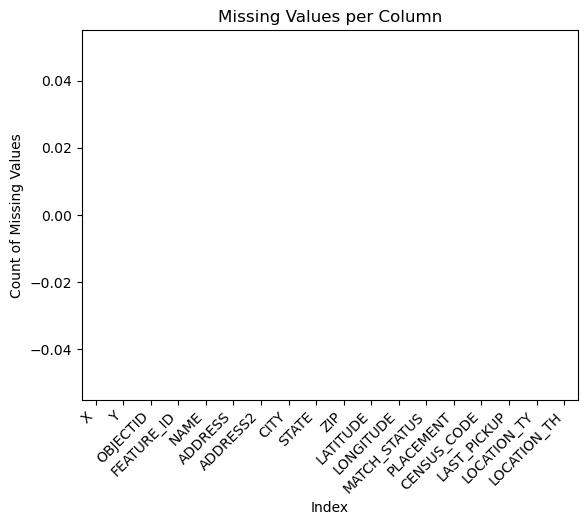

In [6]:
# 1.2 Missing & Anomaly Detection
# 1. Count missing values per column
missing = df.isnull().sum()

# Plotting missing values
sns.barplot(x=missing.index, y=missing.values)
plt.xticks(rotation=45, ha='right')
plt.title("Missing Values per Column")
plt.ylabel("Count of Missing Values")
plt.xlabel("Index")
plt.show()

In [7]:
# 2. Check for invalid ZIP codes (not 5-digit) and convert them to 5 digits using 0 in front.

df['ZIP'] = df['ZIP'].astype(str).str.zfill(5)

invalid_zip = df[~df['ZIP'].str.match(r'^\d{5}$')]
print(f"\nInvalid ZIP codes count: {len(invalid_zip)}")
print(invalid_zip[['CITY', 'STATE', 'ZIP']].head())



Invalid ZIP codes count: 0
Empty DataFrame
Columns: [CITY, STATE, ZIP]
Index: []


In [8]:
# Format ZIP reference codes
zip_df['Zip Code'] = zip_df['Zip Code'].astype(str).str.zfill(5)

# Reference lookup DataFrame
zip_lookup = zip_df[['Zip Code', 'Official USPS city name', 'Official USPS State Code']]
zip_lookup.columns = ['ZIP', 'REF_CITY', 'REF_STATE']

# Merge with DHL data
df = df.merge(zip_lookup, on='ZIP', how='left')

# Check CITY mismatches
city_mismatch = df[df['CITY'].str.upper() != df['REF_CITY'].astype(str).str.upper()]
print("\nCITY mismatches:", len(city_mismatch))
print(city_mismatch[['CITY', 'REF_CITY', 'ZIP']].head())

# Check STATE mismatches
state_mismatch = df[df['STATE'].str.upper() != df['REF_STATE'].astype(str).str.upper()]
print("\nSTATE mismatches:", len(state_mismatch))
print(state_mismatch[['STATE', 'REF_STATE', 'ZIP']].head())


CITY mismatches: 2121
         CITY    REF_CITY    ZIP
6   LEXINGTON         NaN  40536
10  LENOXDALE  Lenox Dale  01242
19     QUEENS  Queensbury  12804
20     QUEENS  Queensbury  12804
25     ALBANY         NaN  12223

STATE mismatches: 114
    STATE REF_STATE    ZIP
6      KY       NaN  40536
25     NY       NaN  12223
162    GA       NaN  30057
175    VA       NaN  22090
179    IN       NaN  46650


In [9]:
# Identify missing or zero coordinates
invalid_geo = df[
    (df['LATITUDE'].isnull()) | (df['LONGITUDE'].isnull()) |
    (df['LATITUDE'] == 0) | (df['LONGITUDE'] == 0)]

print("\nFacilities with invalid LAT/LONG:", len(invalid_geo))
print(invalid_geo[['NAME', 'CITY', 'STATE', 'LATITUDE', 'LONGITUDE']].head())


Facilities with invalid LAT/LONG: 0
Empty DataFrame
Columns: [NAME, CITY, STATE, LATITUDE, LONGITUDE]
Index: []


<Axes: xlabel='MATCH_STATUS'>

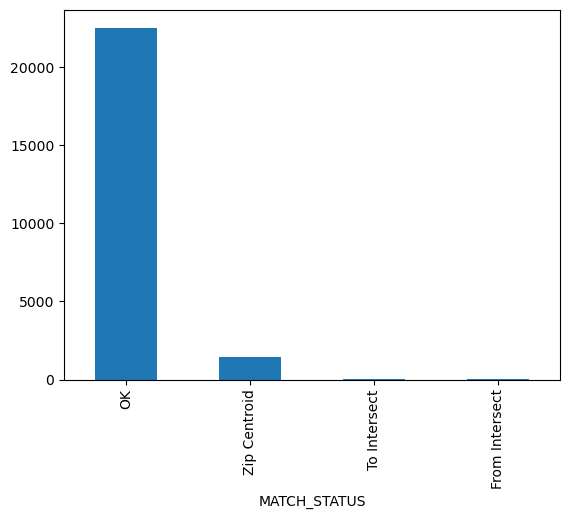

In [10]:
match_status_summary = df['MATCH_STATUS'].value_counts()
match_status_summary

match_status_summary.plot.bar()

## 2. Geographic Distribution & Clustering

In [12]:
#2.1 Regional Density Analysis

#Count facilities by state

state_counts = df.groupby('STATE').size().sort_values(ascending= False)
print(state_counts)

STATE
TX    2223
FL    2101
CA    2004
IL    1336
OH    1260
PA    1077
NJ    1075
NY    1072
GA     986
MI     879
NC     751
VA     645
MO     623
IN     530
MA     527
MD     524
TN     483
CO     453
WA     450
AZ     430
AL     346
SC     317
WI     316
CT     310
LA     297
KY     256
MN     250
KS     242
OR     220
OK     210
IA     206
NV     187
UT     176
AR     172
NE     166
MS     142
ID     112
NM     100
NH      84
DC      79
WV      79
DE      57
MT      55
ME      52
HI      51
RI      40
SD      37
ND      26
VT      24
WY      20
AK      14
dtype: int64


In [13]:
# top and bottom 10 by raw count and per-capita

print("=== Top 10 States by Facility Count ===")
print(state_counts.head(10))

print("\n=== Bottom 10 States by Facility Count ===")
print(state_counts.tail(10))


=== Top 10 States by Facility Count ===
STATE
TX    2223
FL    2101
CA    2004
IL    1336
OH    1260
PA    1077
NJ    1075
NY    1072
GA     986
MI     879
dtype: int64

=== Bottom 10 States by Facility Count ===
STATE
DE    57
MT    55
ME    52
HI    51
RI    40
SD    37
ND    26
VT    24
WY    20
AK    14
dtype: int64


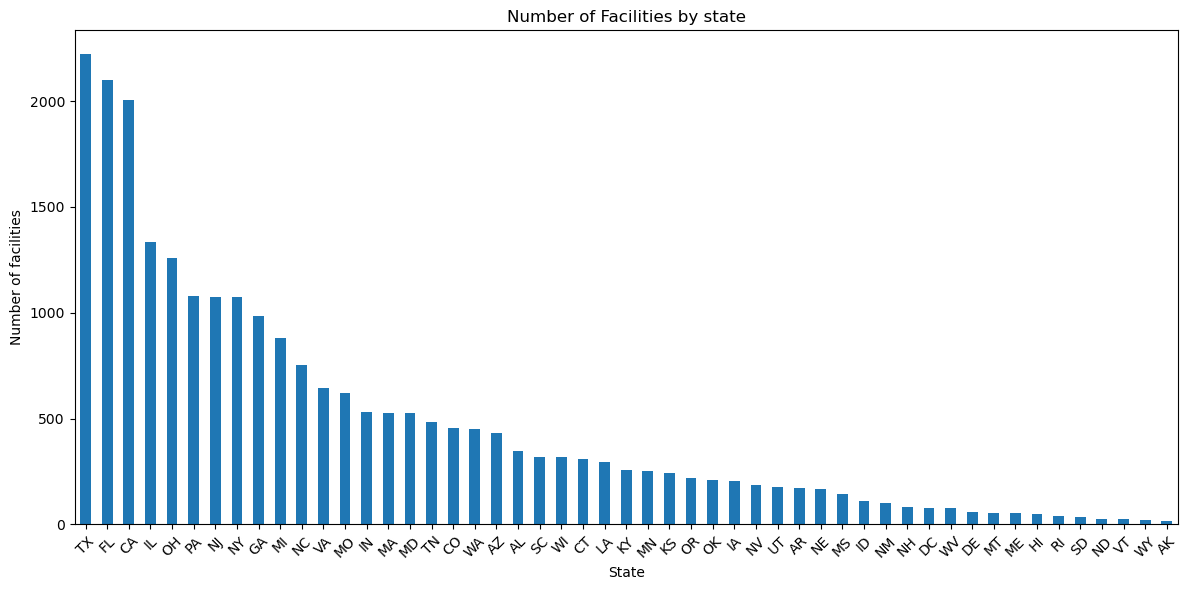

In [14]:
# Aggregate facility counts by STATE

plt.figure(figsize= (12,6))
state_counts.plot(kind = 'bar')
plt.title('Number of Facilities by state')
plt.xticks(rotation=45)
plt.ylabel("Number of facilities")
plt.xlabel("State")
plt.tight_layout()
plt.show()

In [15]:
# Facility count by MSA

facility_msa = df.groupby('CENSUS_CODE').size().sort_values(ascending = False)
facility_msa

CENSUS_CODE
1.70318E+14    401
4.8113E+14     401
1.3121E+14     283
2.91892E+14    254
2.61252E+14    247
              ... 
2.716E+14        1
4.8402E+14       1
2.7158E+14       1
2.7152E+14       1
1.0001E+14       1
Length: 1690, dtype: int64

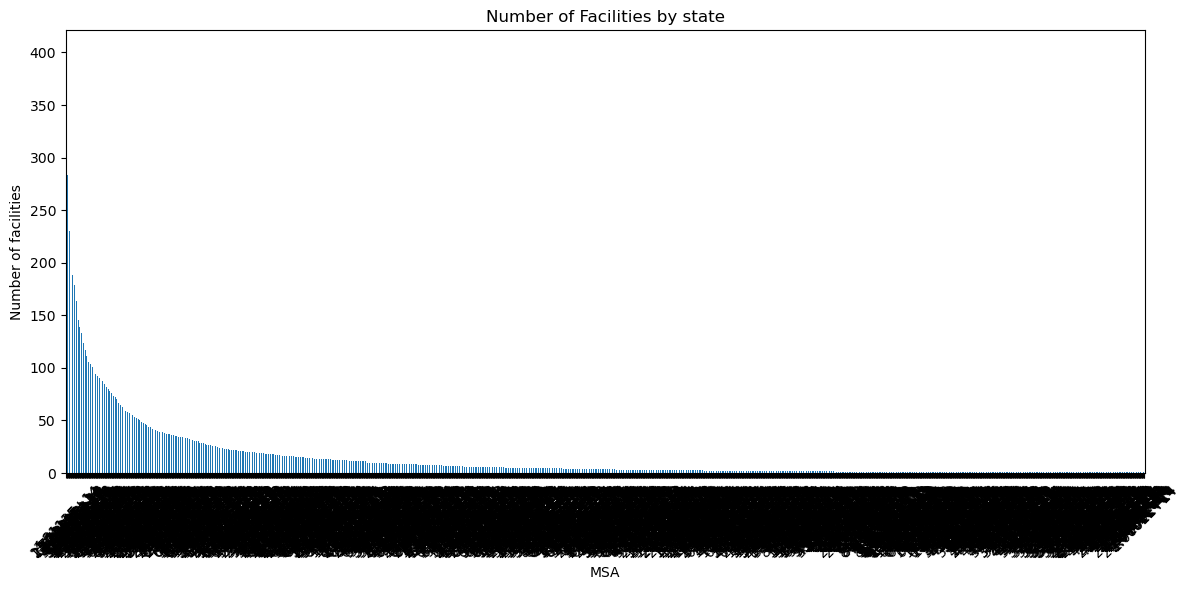

In [16]:
# Aggregate facility counts by Metropolitan Statistical Area (MSA)

plt.figure(figsize= (12,6))
facility_msa.plot(kind = 'bar')
plt.title('Number of Facilities by state')
plt.xticks(rotation=45)
plt.ylabel("Number of facilities")
plt.xlabel("MSA")
plt.tight_layout()
plt.show()

# 3. Categorical & Operational Insights

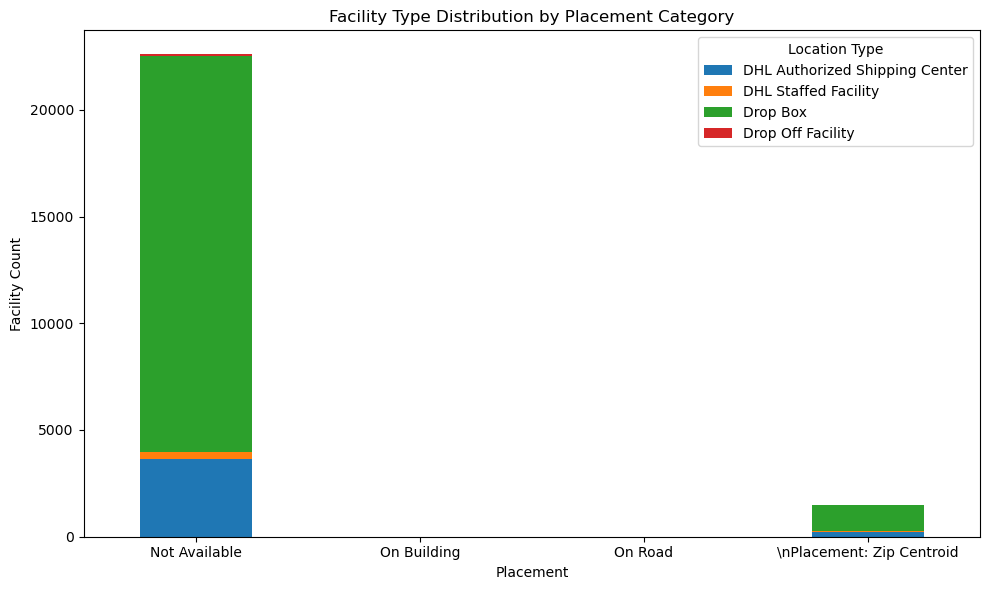

In [18]:
# 3.1 Type & Placement Mix

# Count LOCATION_TY within each PLACEMENT
type_placement_counts = df.groupby(['PLACEMENT', 'LOCATION_TY']).size().unstack().fillna(0)

# Plot stacked bar
type_placement_counts.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title("Facility Type Distribution by Placement Category")
plt.ylabel("Facility Count")
plt.xlabel("Placement")
plt.xticks(rotation=0)
plt.legend(title="Location Type")
plt.tight_layout()
plt.show()

In [40]:
# top 3 states
Facility_type_count = df['PLACEMENT'].value_counts().head(3)

Facility_type_count 

PLACEMENT
Not Available                22594
\nPlacement: Zip Centroid     1469
On Building                      7
Name: count, dtype: int64

In [48]:
## 3.2 Status Analysis

# convert to string categories
df['FACILITY_STATUS'] = df['MATCH_STATUS'].apply(lambda x: 'ACTIVE' if x == True or x == 'OK' else 'INACTIVE')

# Group by state and count active/inactive
status_counts = df.groupby(['STATE', 'FACILITY_STATUS']).size().unstack(fill_value=0)

# total and inactive rate
status_counts['TOTAL'] = status_counts.sum(axis=1)
status_counts['INACTIVE_RATE'] = status_counts['INACTIVE'] / status_counts['TOTAL']

# Sort and display
inactive_sorted = status_counts.sort_values(by='INACTIVE_RATE', ascending=False)

print("Top 10 States by Inactive Facility Rate:\n")
print(inactive_sorted[['INACTIVE_RATE']].head(10))

Top 10 States by Inactive Facility Rate:

FACILITY_STATUS  INACTIVE_RATE
STATE                         
SD                    0.162162
DE                    0.157895
WV                    0.113924
NC                    0.113182
MS                    0.112676
MO                    0.110754
RI                    0.100000
KY                    0.097656
ME                    0.096154
OK                    0.095238


In [58]:
# Cross-tab of STATUS vs LOCATION_TY 
status_vs_type = pd.crosstab(df['MATCH_STATUS'],df['LOCATION_TY'])
status_vs_type

LOCATION_TY,DHL Authorized Shipping Center,DHL Staffed Facility,Drop Box,Drop Off Facility
MATCH_STATUS,,,,
From Intersect,0,0,16,0
OK,3645,307,18494,80
To Intersect,1,0,59,1
Zip Centroid,239,19,1207,4


# 4. Temporal & Utilization Trends

0       NaT
1       NaT
2       NaT
3       NaT
4       NaT
         ..
24067   NaT
24068   NaT
24069   NaT
24070   NaT
24071   NaT
Name: LAST_PICKUP, Length: 24072, dtype: datetime64[ns]

In [105]:
# Convert LAST_PICKUP to datetime; extract year, month, and weekday
df['LAST_PICKUP'] = pd.to_datetime(df['LAST_PICKUP'], errors='coerce')

# Extract components
df['PICKUP_MONTH'] = df['LAST_PICKUP'].dt.to_period('M')
df['PICKUP_WEEKDAY'] = df['LAST_PICKUP'].dt.day_name()
df['PICKUP_YEAR'] = df['LAST_PICKUP'].dt.year
df['PICKUP_HOUR'] = df['LAST_PICKUP'].dt.hour

## NOTE: The LAST_PICKUP are business hours, not timestamps of when a pickup occurred. This column cannot be used for time-series analysis. however i have wrote the necessary code for the required question.

C:\Users\Hp\AppData\Local\Temp\ipykernel_16848\3371686516.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['LAST_PICKUP_DT'] = pd.to_datetime(df['LAST_PICKUP'], errors='coerce')


AttributeError: Can only use .dt accessor with datetimelike values

In [109]:
# Get latest pickup date and filter for last 2 years
latest = df['LAST_PICKUP'].max()
cutoff = latest - pd.DateOffset(years=2)

recent = df[df['LAST_PICKUP'] >= cutoff]

# Group and count monthly pickups
monthly = recent['PICKUP_MONTH'].value_counts().sort_index()

# Plot
monthly.plot(kind='line', marker='o', figsize=(10, 5))
plt.title("Monthly Pickup Counts (Last 2 Years)")
plt.xlabel("Month")
plt.ylabel("Number of Facilities with Pickups")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

TypeError: unsupported operand type(s) for -: 'str' and 'DateOffset'

In [ ]:
# Filter valid pickup times
pickup_times = df.dropna(subset=['PICKUP_WEEKDAY', 'PICKUP_HOUR'])

# pivot table
heatmap_data = pickup_times.pivot_table(
    index='PICKUP_WEEKDAY',
    columns='PICKUP_HOUR',
    values='FACILITY_ID',
    aggfunc='count'
).fillna(0)

# Reorder days for clarity
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
heatmap_data = heatmap_data.reindex(days_order)

# Plot
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap='YlOrRd', linewidths=0.3)
plt.title("Pickup Frequency by Weekday and Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week")
plt.tight_layout()
plt.show()

In [ ]:
## 4.2 Dormancy Analysis

from datetime import datetime

# Calculate days since last pickup
today = pd.Timestamp.now()
df['DAYS_SINCE_LAST_PICKUP'] = (today - df['LAST_PICKUP']).dt.days

# Flags for dormancy
df['DORMANT_30'] = df['DAYS_SINCE_LAST_PICKUP'] > 30
df['DORMANT_60'] = df['DAYS_SINCE_LAST_PICKUP'] > 60
df['DORMANT_90'] = df['DAYS_SINCE_LAST_PICKUP'] > 90

# Summary
print("Dormant Facilities Summary:")
print(f">30 days: {df['DORMANT_30'].sum()}")
print(f">60 days: {df['DORMANT_60'].sum()}")
print(f">90 days: {df['DORMANT_90'].sum()}")

# 5. Business-Driven Recommendations

In [120]:
# 5.1 Expansion Priorities

# 5 underserved MSAs (low facility density per capita) for new openings.

facility_msa = df.groupby('CENSUS_CODE').size().sort_values(ascending = False).tail(5)
facility_msa

CENSUS_CODE
2.716E+14     1
4.8402E+14    1
2.7158E+14    1
2.7152E+14    1
1.0001E+14    1
dtype: int64

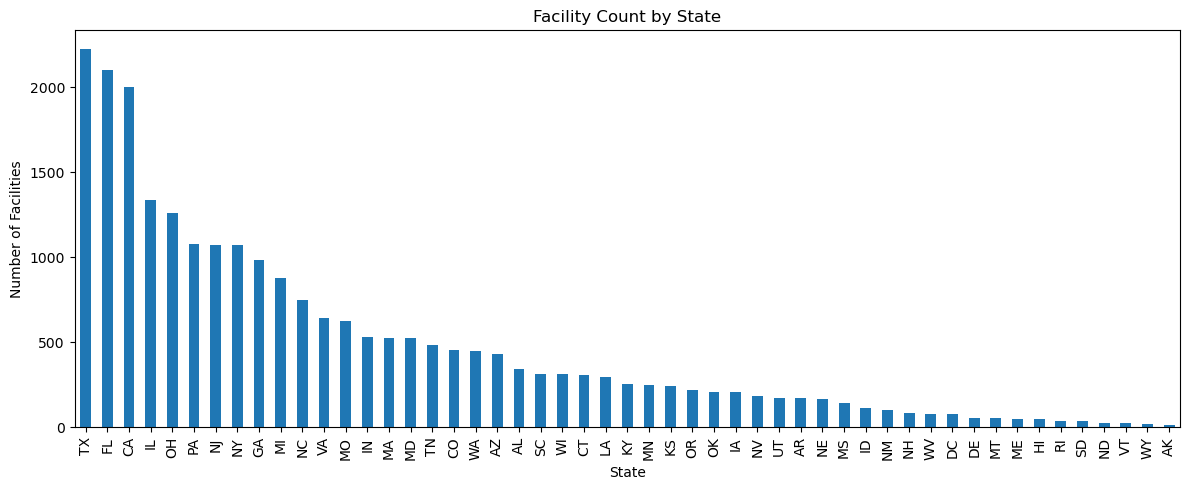

In [128]:
# Recommend one state with strong pickup-volume growth but limited facility expansion

facility_counts = df['STATE'].value_counts().sort_values(ascending=False)

facility_crosstab = pd.crosstab(index=df['STATE'], columns='FACILITY_COUNT')

facility_counts.plot(kind='bar', figsize=(12, 5))
plt.title("Facility Count by State")
plt.xlabel("State")
plt.ylabel("Number of Facilities")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [134]:
# 5.2: Resource Allocation Recommendations

## Optimal Times for Extra Pickup Crew Deployment

weekday_df =  df[['FEATURE_ID', 'PICKUP_WEEKDAYS']].explode('PICKUP_WEEKDAYS')

weekday_counts = weekday_df['PICKUP_WEEKDAYS'].value_counts().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
)

print("Pickup Volume by Weekday:")
print(weekday_counts)

plt.figure(figsize=(10, 5))
sns.histplot(df['PICKUP_HOUR'].dropna(), bins=12, kde=False)
plt.title("Pickup Distribution by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Facilities")
plt.tight_layout()
plt.show()

KeyError: "['PICKUP_WEEKDAYS'] not in index"